In [262]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

Part 1: Blob Detection

In [263]:
def get_sift_output(image):
    #convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints = sift.detect(image, None)
    output_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return sift,keypoints, output_image

In [264]:
def print_sift_parameters(sift):
    """Print SIFT detector parameters  
    
    """
    print("Default SIFT Parameters:")
    print(f"  Number of Features: {sift.getNFeatures()}")
    print(f"  Contrast Threshold: {sift.getContrastThreshold()}")
    print(f"  Edge Threshold: {sift.getEdgeThreshold()}")
    print(f"  Sigma: {sift.getSigma()}")
    print(f"  Number of Octave Layers: {sift.getNOctaveLayers()}")


### SIFT Parameters
1. nfeatures: If we detect thousands of interesting spots, we only take the top few(nfeatures) most distinctive ones.

2. nOctaveLayers: 
```
    - copy opf image at different resolution/zoom level
    - within each octave, SIFT applies multiple gaussian blurs with incresing sigma (increasing blur levels)
```

3. contrastThreshold: ignore weak, low contrast features
```
In OpenCV, it internally divides this threshold by nOctaveLayers, so for Lowe’s paper value (0.03), you actually use 0.09 when nOctaveLayers=3.

```

4. edgeThreshold: filters out features that look like edges rather than corner or blobs.

5. sigma: amount of initial Gaussian blur applied to image before building the pyramid


In [265]:
print_sift_parameters(cv2.SIFT_create())

Default SIFT Parameters:
  Number of Features: 0
  Contrast Threshold: 0.04
  Edge Threshold: 10.0
  Sigma: 1.6
  Number of Octave Layers: 3


In [266]:
def get_tuned_sift_output(image, nfeatures=0, edgeThreshold=6, contrastThreshold=0.04, nOctaveLayers=3, sigma=1.6):
    #convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(nfeatures=nfeatures, edgeThreshold=edgeThreshold, contrastThreshold=contrastThreshold, nOctaveLayers=nOctaveLayers, sigma=sigma)

    keypoints = sift.detect(image, None)
    output_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return sift, keypoints, output_image

In [267]:
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

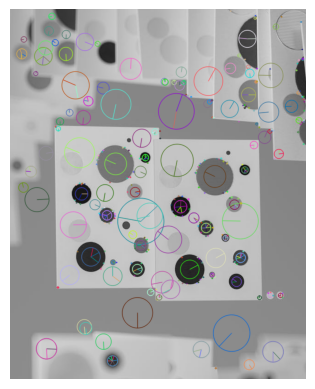

In [268]:
img = cv2.imread('./images/blob_image.jpg')
sift,keypoints, output_image = get_sift_output(img)
plot_image(output_image)

In [269]:
len(keypoints)

387

Part 2: Tunning blob detection performance

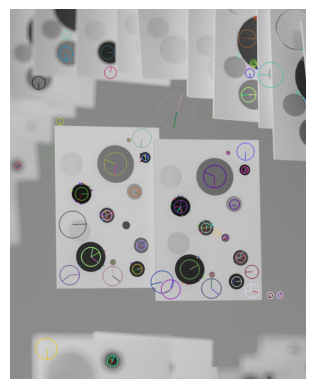

In [270]:
# img = cv2.imread('./images/sunflower.jpg')
nfeatures=0 # 0 is default means, no limit
edgeThreshold=10 # default is 10
contrastThreshold=0.08 # default is 0.04
nOctaveLayers=4 #default is 3
sigma=1.8 # default is 1.6

sift_tuned, keypoints_tuned, output_image_tuned = get_tuned_sift_output(img, nfeatures=nfeatures, edgeThreshold=edgeThreshold, contrastThreshold=contrastThreshold, nOctaveLayers=nOctaveLayers, sigma=sigma)
plot_image(output_image_tuned)

In [271]:
len(keypoints_tuned)

195

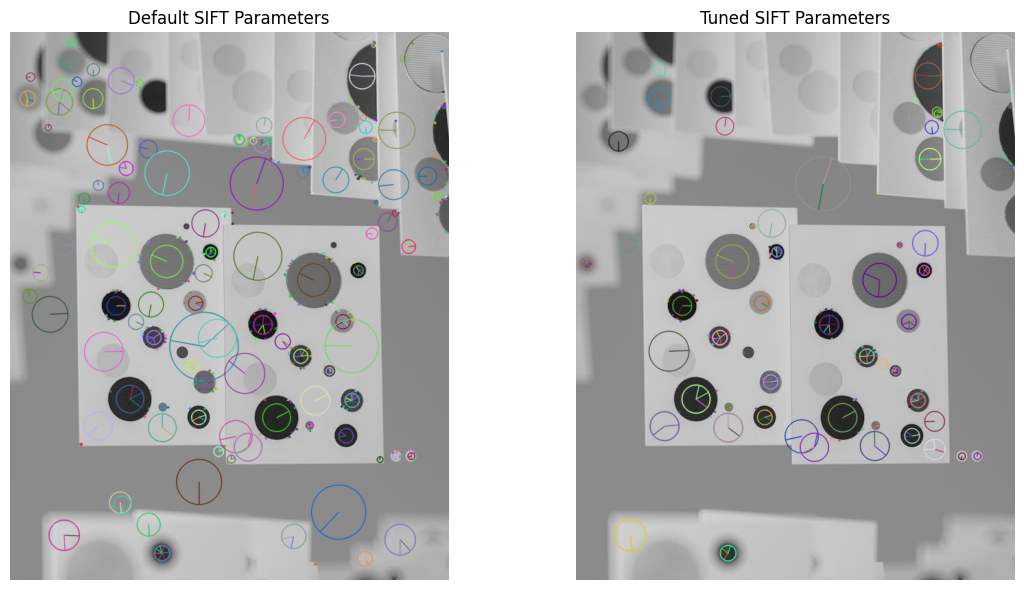

In [272]:
# Plot both output_image, output_image_tuned in same figure and write to outputs folder
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(output_image)
axs[0].set_title('Default SIFT Parameters')
axs[0].axis('off')
axs[1].imshow(output_image_tuned)
axs[1].set_title('Tuned SIFT Parameters')
axs[1].axis('off')
plt.tight_layout()
plt.savefig('outputs/sift_comparison.png')
plt.show()

It is clear that larger circles are being drawn for larger blob features in the image. Additionally, we can control the number of generated keypoints using different parameters. The nfeatures gives the top 'n' most distinctive features, the contrastThreshold sets the minimum conterast required for a keypoint to be considered significant. We can select the number of octaves for the image, to identify smaller blobs, we need larger number of octaves. Additionally we can select sigma which is the amount of gaussian blur applied on the input image. A higher sigma value results in more blurring, which can help in reducing noise and focusing on larger features, while a lower sigma value preserves finer details and smaller features in the image.

For this particular example, I increased the default value of the contrastThreshold because I observed that the blobs are separated by distinct colors. Additionally to bettter detect smaller blobs, I increased the number of octave layers to 4. Besides this I used sigma 1.8, because there were lots of noisy keypoints in the default setting. After these parameter changes, I reduced the keypoints to 195 from 387, which the default setting generated.



Part 3: Descriptors

In [273]:
keypoints_all = [keypoints, keypoints_tuned]
sift_all = [sift, sift_tuned]

for i, (sft, kp) in enumerate(zip(sift_all, keypoints_all)):
    print(f"SIFT Configuration {i+1}:")
    # Sift Descriptors
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sft.compute(gray, kp)
    print(f"  Number of Keypoints: {len(kp)}")
    print(f"  Descriptor Shape: {descriptors.shape}")
    print()

SIFT Configuration 1:
  Number of Keypoints: 387
  Descriptor Shape: (387, 128)

SIFT Configuration 2:
  Number of Keypoints: 195
  Descriptor Shape: (195, 128)



In [274]:
keypoints = keypoints_tuned
sift = sift_tuned

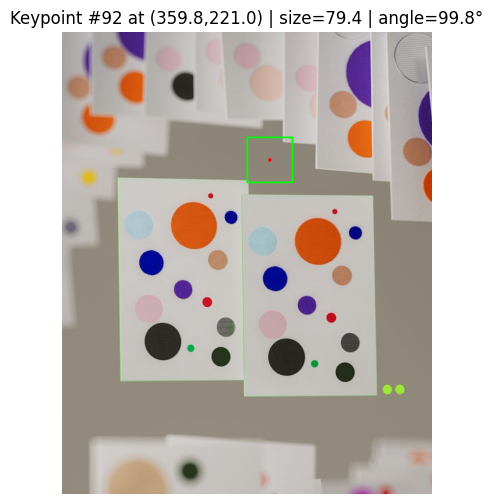

True

In [275]:
# Pick one keypoint to inspect (largest scale is a good demo)
kp_idx = int(np.argmax([kp.size for kp in keypoints]))
kp = keypoints[kp_idx]
desc = descriptors[kp_idx]  # 128-D vector

# Draw center + scale-based rectangle
vis = img.copy()
x, y = map(int, kp.pt)
d = int(round(kp.size))  # side length ~ scale
cv2.circle(vis, (x, y), 3, (0, 0, 255), -1)
cv2.rectangle(vis, (x - d//2, y - d//2), (x + d//2, y + d//2), (0, 255, 0), 2)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.title(f"Keypoint #{kp_idx} at ({kp.pt[0]:.1f},{kp.pt[1]:.1f}) | size={kp.size:.1f} | angle={kp.angle:.1f}°")
plt.show()

#write image to outputs
cv2.imwrite('outputs/sift_tuned_keypoint_inspection.png', vis)

In [276]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sift_4x4(desc128):
    """
    Visualize a 128-D SIFT descriptor as a 4x4 grid of 8-bin orientation histograms.
    - X-axis: Orientation bins (0° to 360°)
    - Y-axis: Normalized gradient magnitude
    """
    assert desc128.shape == (128,), "Expected a single 128-D descriptor"

    # Reshape to [4x4 cells, each with 8 orientation bins]
    cells = desc128.reshape(4, 4, 8)
    bins = np.linspace(0, 360, 8, endpoint=False)  # Orientation centers (degrees)

    fig, axes = plt.subplots(4, 4, figsize=(9, 9))
    fig.suptitle("SIFT descriptor: 4×4 spatial cells × 8 orientation bins", fontsize=13, y=0.94)

    for r in range(4):
        for c in range(4):
            ax = axes[r, c]
            hist = cells[r, c]

            # Normalize for visualization clarity (not required mathematically)
            hist = hist / (np.linalg.norm(hist) + 1e-9)

            ax.bar(bins, hist, width=40, align='center', color='royalblue', edgecolor='black')

            # Axis labeling
            ax.set_xlim(0, 360)
            ax.set_ylim(0, 1)
            if r == 3:
                ax.set_xlabel("Orientation (°)", fontsize=8)
            if c == 0:
                ax.set_ylabel("Grad. Strength", fontsize=8)

            ax.set_xticks([0, 90, 180, 270])
            ax.set_yticks([0, 0.5, 1.0])
            ax.tick_params(axis='both', labelsize=7)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    #write plot to outputs
    fig.savefig('outputs/sift_descriptor_visualization.png')


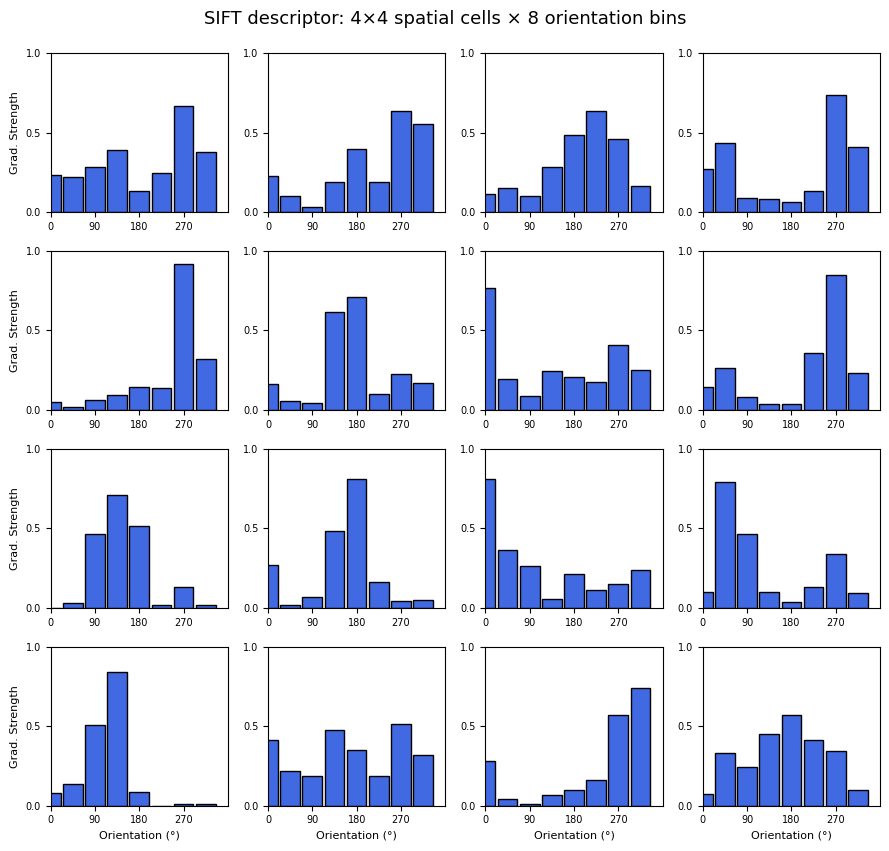

In [277]:
plot_sift_4x4(desc)

For a particular keypoint that we selected:
- A **SIFT descriptor** captures the appearance around the keypoint using gradients within a small region of the image called a **local image patch**.
- This patch is divided into a **4×4 grid**, creating **16 smaller cells** that preserve spatial information about where gradients occur.
- Each of these 16 cells contains an **8-bin histogram**, where each bin represents edge orientations in **45° intervals** (0°, 45°, 90°, …, 315°).
- The **height of each bin** indicates how strong the edges are in that particular direction within that part of the patch.
- When all 16 histograms are concatenated, they form a **128-dimensional vector** that uniquely describes the keypoint’s local structure.
- This representation makes SIFT features **robust to scale, rotation, and illumination changes**, allowing reliable keypoint matching across different images.


Part 4: Feature Mapping

In [ ]:
def plot_sift_matches(image1, image2, n_matches=50, gap=60, pad_color=(255,255,255), sift=cv2.SIFT_create()):
    """
    Detects SIFT features in two images, matches them with BFMatcher,
    and plots the top N matches with a white border in between.
    Returns the matched image (BGR array).
    """

    # Convert to grayscale if needed
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY) if image1.ndim == 3 else image1
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY) if image2.ndim == 3 else image2

    # --- SIFT detect + compute ---
    sift = sift
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # --- Brute-Force match ---
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = sorted(bf.match(des1, des2), key=lambda m: m.distance)

    # --- prepare white gap before drawing ---
    h, w = image1.shape[:2]
    pad = np.full((h, gap, 3), pad_color, dtype=np.uint8)
    combined = np.hstack((image1, pad, image2))

    # Shift keypoints2 by image1 width + gap
    shifted_kp2 = [
        cv2.KeyPoint(k.pt[0] + w + gap, k.pt[1], k.size, k.angle,
                     k.response, k.octave, k.class_id)
        for k in kp2
    ]

    # --- draw matches manually across the border ---
    matched_img = combined.copy()
    for m in matches[:n_matches]:
        pt1 = tuple(np.round(kp1[m.queryIdx].pt).astype(int))
        pt2 = tuple(np.round(shifted_kp2[m.trainIdx].pt).astype(int))
        color = tuple(np.random.randint(0, 255, 3).tolist())
        cv2.line(matched_img, pt1, pt2, color, 1)
        cv2.circle(matched_img, pt1, 4, color, -1)
        cv2.circle(matched_img, pt2, 4, color, -1)

    # --- show the plot ---
    plt.figure(figsize=(14,7))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Top {n_matches} SIFT Matches (with border)")
    plt.show()

    return matched_img


: 

In [ ]:
import cv2, numpy as np, matplotlib.pyplot as plt

# --- prepare original and transformed images ---
image1 = img
h, w = image1.shape[:2]

M_rot = cv2.getRotationMatrix2D((w/2, h/2), 30, 1.0)
M_rot[0,2] += 50  # shift right
M_rot[1,2] += 30  # shift down
image2 = cv2.warpAffine(image1, M_rot, (w, h))

cv2.imwrite("outputs/blob_transformed.jpg", image2)


True

: 

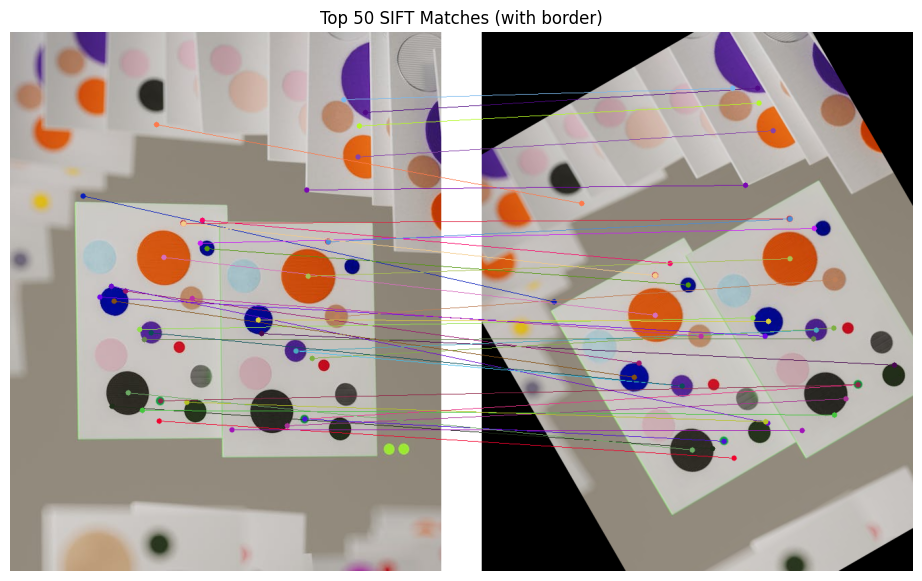

True

In [278]:
matched_image = plot_sift_matches(image1, image2, n_matches=50, gap=60, pad_color=(255,255,255), sift=sift)
cv2.imwrite('outputs/sift_matched_blob.png', matched_image)

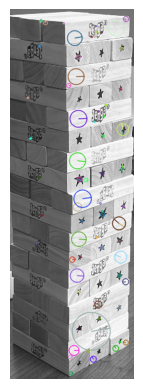

: 

In [ ]:
img_jenga_1 = cv2.imread('./images/jenga_side_rotated.png')
img_jenga_2 = cv2.imread('./images/jenga_side.png')

#resize both images to have same height and width
img_jenga_1 = cv2.resize(img_jenga_1, (200,600))
img_jenga_2 = cv2.resize(img_jenga_2, (200,600))
nfeatures=0 # 0 is default means, no limit
edgeThreshold=4 # default is 10
contrastThreshold=0.08 # default is 0.04
nOctaveLayers=4 #default is 3
sigma=2.4 # default is 1.6

sift_tuned, keypoints_tuned, output_image_tuned = get_tuned_sift_output(img_jenga_2, nfeatures=nfeatures, edgeThreshold=edgeThreshold, contrastThreshold=contrastThreshold, nOctaveLayers=nOctaveLayers, sigma=sigma)
plot_image(output_image_tuned)

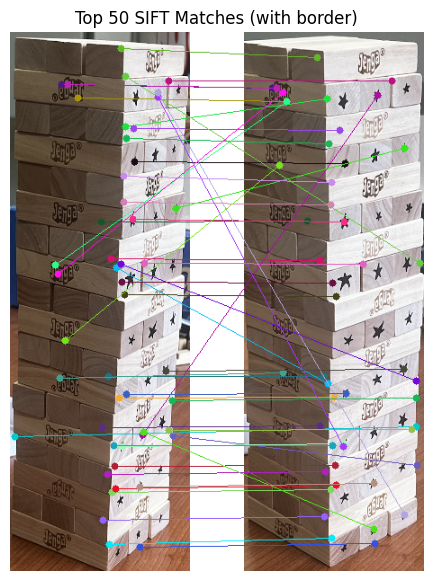

True

In [279]:
matched_image = plot_sift_matches(img_jenga_1, img_jenga_2, n_matches=50, gap=60, pad_color=(255,255,255), sift=sift_tuned)
cv2.imwrite('outputs/sift_matched_jenga.png', matched_image)